In [41]:
# !pip install pgmpy --upgrade
# !pip install numpy cython
# !pip install hmms --use-pep517
# !pip install --upgrade --user hmmlearn
# !pip install networkx[default]

In [2]:
EIA_TOKEN="SkISq5ivyi0kHjp7gjiS5eAH4EZ3RAGOuCeCIcha"
import os
os.environ["EIA_TOKEN"]=EIA_TOKEN

In [3]:
import pandas as pd
from fredapi import Fred
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox,probplot,shapiro
# from myeia.api import API
from myeia.api import API
from hmmlearn import hmm
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import BicScore, K2Score, BDeuScore

import networkx as nx
import pylab as plt

import warnings
warnings.filterwarnings('ignore')
from numpy import hstack
plt.rcParams["figure.figsize"] = (16, 9)

In [4]:

fred = Fred(api_key='c2ba2ab669806771ed51f532edc6e570')

# **FROM PROJECT-I**

**Get the datasets**

In [5]:
# We will try and get the latest dataset
start_date="2014-01-01"
end_date="2023-09-30"

In [6]:
# Define a list of FRED series/ticker names
macro_tickers = ["GEPUCURRENT", "UNRATE", "T30YIEM",'EMVELECTGOVRN','WTISPLC']

# Create a dictionary to store the data
macro_pd = pd.DataFrame()

# Loop through the tickers and fetch data
for ticker in macro_tickers:
    macro_pd[ticker] = fred.get_series(ticker,observation_start=start_date, observation_end=end_date)

# # Print or process the data as needed
# for ticker, series_data in macro_data.items():
#     print(f"Data for {ticker}:")
#     print(series_data)


In [7]:
micro_fuel = pd.DataFrame(fred.get_series('APU000072511',observation_start=start_date, observation_end=end_date), columns=['Fuel'])
micro_employ = pd.DataFrame(fred.get_series('CES1021100001',observation_start=start_date, observation_end=end_date), columns=['Sector_employment'])

In [8]:
frames = [micro_fuel, micro_employ]

micro_data = pd.concat(frames, axis=1)

In [9]:
eia = API()

In [10]:
oil_price_series=[
            "EER_EPD2DC_PF4_Y05LA_DPG",
            "EER_EPD2DXL0_PF4_RGC_DPG",
            "EER_EPD2DXL0_PF4_Y35NY_DPG",
        ]
fin_data = eia.get_series_via_route(
    route="petroleum/pri/spt",
    series=oil_price_series,
    frequency="monthly",
    facet="series",
    start_date=start_date,
    end_date=end_date
)
fin_data.head()

,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel Spot Price (Dollars per Gallon)",U.S. Gulf Coast Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon),New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)
Date,,,
2023-08-01,3.437,3.050,3.117
2023-07-01,2.817,2.597,2.671
2023-06-01,2.415,2.351,2.432
2023-05-01,2.386,2.302,2.346
2023-04-01,2.418,2.518,2.593


**Clean the dataset**

In [11]:

 # Check for and remove duplicated rows.
macro_pd_cleaned_ = macro_pd[~macro_pd.index.duplicated(keep='first')]

# # Handling missing values using linear interpolation
macro_pd_cleaned_ = macro_pd_cleaned_.interpolate(method='linear')

In [12]:
# Check for and remove duplicated rows.
micro_data_cleaned_ = micro_data[~micro_data.index.duplicated(keep='first')]

# Handling missing values using linear interpolation
micro_data_cleaned_ = micro_data_cleaned_.interpolate(method='linear')

In [13]:
# Check for and remove duplicated rows.
fin_data_cleaned_ = fin_data[~fin_data.index.duplicated(keep='first')]

# Handling missing values using linear interpolation
fin_data_cleaned_ = fin_data_cleaned_.interpolate(method='linear')

**Merge the time series**

In [14]:
# Merge the dataframes based on their datetime index
sterilized_df = fin_data_cleaned_.merge(micro_data_cleaned_, left_index=True, right_index=True, how='outer')
sterilized_df = sterilized_df.merge(macro_pd_cleaned_, left_index=True, right_index=True, how='outer')

# **FROM PROJECT-II**

## latent meaning behind each hidden state

Now since, the hmm module that Alvi used is outdated and only runs on Python5, we have implement a new version using hmmlearn.

In [22]:
train_data = sterilized_df[: int(sterilized_df.shape[0] * 0.80)];
vald_data = sterilized_df[int(0.80 * sterilized_df.shape[0]) : int(0.90 * sterilized_df.shape[0])];
test_data = sterilized_df[int(0.90* sterilized_df.shape[0]) : int(sterilized_df.shape[0])];

In [23]:
price = train_data['WTISPLC']

In [24]:
# train_data

In [25]:
train_data_series = train_data.stack()

In [26]:
# The first value is NaN as there is not a previous month to compare with
price_diff = price.diff()[1:];
# Replacing the change with 1 if positive, else 0
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values);

**Learn HMM Parameters with Baum-Welch:**

We will need a Python library that supports Hidden Markov Models, such as the hmmlearn library.Below is how to use the Baum-Welch algorithm to estimate the parameters of an HMM using hmmlearn module:

In [27]:


# Define the number of hidden states (e.g., bull, bear, stagnant)
n_states = 3

# Create an HMM model with the specified number of states
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")

# Fit the model to the observed data (e.g., e_seq)
model.fit(e_seq.reshape(-1, 1))

# Retrieve the learned model parameters, including transition probabilities, means, and covariances
transition_matrix = model.transmat_
means = model.means_
covariances = model.covars_

**Use the Viterbi Algorithm to Identify Market Regimes:**

After learning the HMM parameters, we use the Viterbi Algorithm to find the most likely sequence of hidden states (market regimes) that generated the observed data. Here's how we apply the Viterbi Algorithm:

In [28]:
# Use the learned model to predict the most likely state sequence
s_seq = model.predict(e_seq.reshape(-1, 1))

# Map the predicted states to human-readable market regime names
market_regimes = {0: "Bear", 1: "Stagnant", 2: "Bull"}
regime_sequence = [market_regimes[state] for state in s_seq]

# Add the regime sequence as a new column in price_plot
# price_plot['Market Regime'] = regime_sequence


The rest of the codes is adopted from Alvis work

In [29]:
# Add price
price_plot = pd.DataFrame(price[1:], index=price[1:].index);
# Add a column representing the regime
price_plot['Regime'] = s_seq
# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff;

In [30]:
# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean();
lst_1 = means.index.tolist();
lst_2 = means.sort_values().index.tolist();
map_regimes = dict(zip(lst_2, lst_1));
price_plot['Regime'] = price_plot['Regime'].map(map_regimes);

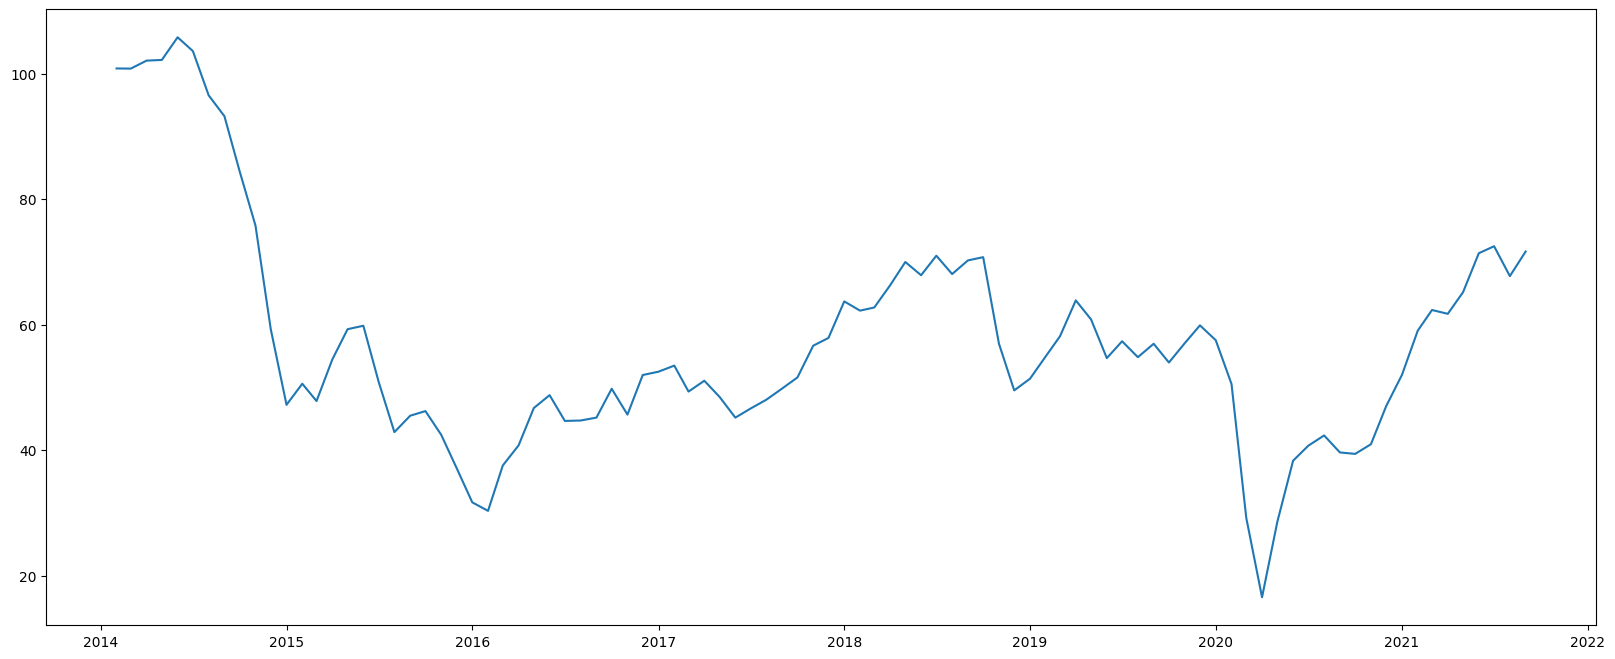

In [31]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
fig, ax1 = plt.subplots(figsize=(20,8));
ax1.plot(price_plot['WTISPLC']);
# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green
cmap = ListedColormap(['r','b','g'],'indexed');
norm = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);
lc = LineCollection(segments, cmap=cmap, norm=norm);

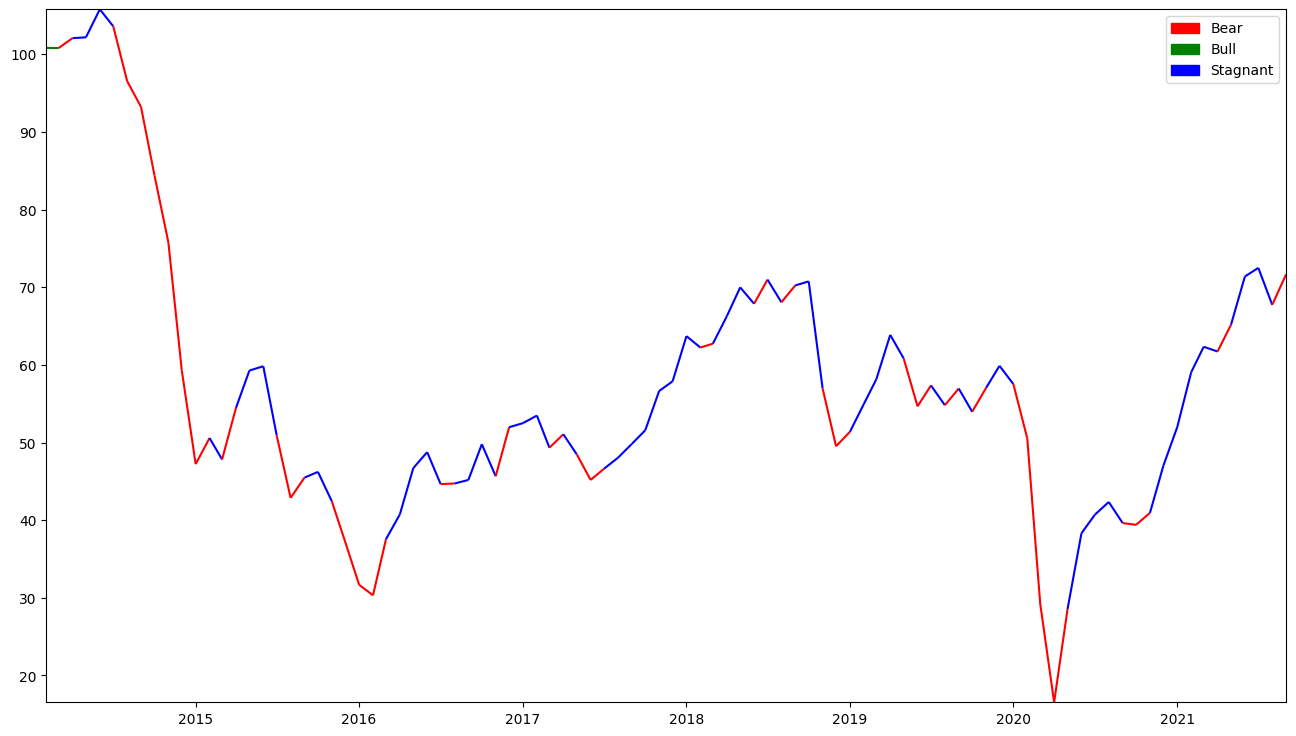

In [32]:
lc.set_array(price_plot['Regime']);
plt.gca().add_collection(lc);
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max());
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max());
r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');
plt.legend(handles=[r_patch, g_patch, b_patch]);
plt.show();

In [33]:
# !pip uninstall  hmmlearn

# **STEP 9: Hill Climb search**

In [34]:
# list(price)

In [35]:
# train_data

# Your original Series
price_series = pd.Series(price)

# Convert the Series to a DataFrame
price_df = price_series.reset_index()

# Rename the columns to 'Date' and 'Value' (or other desired column names)
price_df.columns = ['Date', 'WTISPLC']

# Set the 'Date' column as the index
price_df.set_index('Date', inplace=True)
# Display the resulting DataFrame
print(price_df)


            WTISPLC
Date               
2014-01-01    94.62
2014-02-01   100.82
2014-03-01   100.80
2014-04-01   102.07
2014-05-01   102.18
...             ...
2021-05-01    65.17
2021-06-01    71.38
2021-07-01    72.49
2021-08-01    67.73
2021-09-01    71.65

[93 rows x 1 columns]


In [36]:


# Convert the index to a list of dates and values to a list of values
date_list = price.index.tolist()
value_list = price.values.tolist()

# Combine the date and value lists into an array
result_array = np.array([[date, value] for date, value in zip(date_list, value_list)])

# print(result_array)


In [37]:
import random
import numpy as np
import networkx as nx
 
#coordinate of the date/spot price value
# coordinate = np.array([[1,2], [30,21], [56,23], [8,18], [20,50], [3,4], [11,6], [6,7], [15,20], [10,9], [12,12]])
coordinate=result_array
 
#adjacency matrix for a weighted graph based on the given coordinates
def generate_matrix(coordinate):
    matrix = []
    for i in range(len(coordinate)):
        for j in range(len(coordinate)) :       
            p = np.linalg.norm(coordinate[i] - coordinate[j])
            matrix.append(p)
    matrix = np.reshape(matrix, (len(coordinate),len(coordinate)))
    #print(matrix)
    return matrix
 
#finds a random solution    
def solution(matrix):
    points = list(range(0, len(matrix)))
    solution = []
    for i in range(0, len(matrix)):
        random_point = points[random.randint(0, len(points) - 1)]
        solution.append(random_point)
        points.remove(random_point)
    return solution
 
 
#calculate the path based on the random solution
def path_length(matrix, solution):
    cycle_length = 0
    for i in range(0, len(solution)):
        cycle_length += matrix[solution[i]][solution[i - 1]]
    return cycle_length
 
#generate neighbors of the random solution by swapping cities and returns the best neighbor
def neighbors(matrix, solution):
    neighbors = []
    for i in range(len(solution)):
        for j in range(i + 1, len(solution)):
            neighbor = solution.copy()
            neighbor[i] = solution[j]
            neighbor[j] = solution[i]
            neighbors.append(neighbor)
             
    #assume that the first neighbor in the list is the best neighbor      
    best_neighbor = neighbors[0]
    best_path = path_length(matrix, best_neighbor)
     
    #check if there is a better neighbor
    for neighbor in neighbors:
        current_path = path_length(matrix, neighbor)
        if current_path < best_path:
            best_path = current_path
            best_neighbor = neighbor
    return best_neighbor, best_path
 
 
def hill_climbing(coordinate):
    matrix = generate_matrix(coordinate)
     
    current_solution = solution(matrix)
    current_path = path_length(matrix, current_solution)
    neighbor = neighbors(matrix,current_solution)[0]
    best_neighbor, best_neighbor_path = neighbors(matrix, neighbor)
 
    while best_neighbor_path < current_path:
        current_solution = best_neighbor
        current_path = best_neighbor_path
        neighbor = neighbors(matrix, current_solution)[0]
        best_neighbor, best_neighbor_path = neighbors(matrix, neighbor)
 
    return current_path, current_solution
final_solution = hill_climbing(price)
print("The solution is \n", final_solution[1])

The solution is 
 [75, 76, 23, 26, 77, 12, 40, 15, 62, 92, 4, 6, 5, 69, 60, 39, 45, 37, 85, 17, 64, 49, 86, 87, 71, 11, 16, 47, 20, 31, 30, 22, 79, 19, 14, 38, 66, 56, 54, 89, 90, 9, 7, 3, 1, 2, 0, 8, 10, 57, 29, 43, 83, 28, 42, 21, 34, 41, 32, 80, 81, 78, 27, 82, 67, 61, 68, 46, 65, 35, 44, 33, 59, 73, 13, 18, 84, 36, 58, 70, 72, 50, 88, 51, 91, 53, 55, 52, 63, 48, 24, 25, 74]


In [38]:
len(final_solution[1])

93

In [39]:
price

2014-01-01     94.62
2014-02-01    100.82
2014-03-01    100.80
2014-04-01    102.07
2014-05-01    102.18
               ...  
2021-05-01     65.17
2021-06-01     71.38
2021-07-01     72.49
2021-08-01     67.73
2021-09-01     71.65
Freq: MS, Name: WTISPLC, Length: 93, dtype: float64

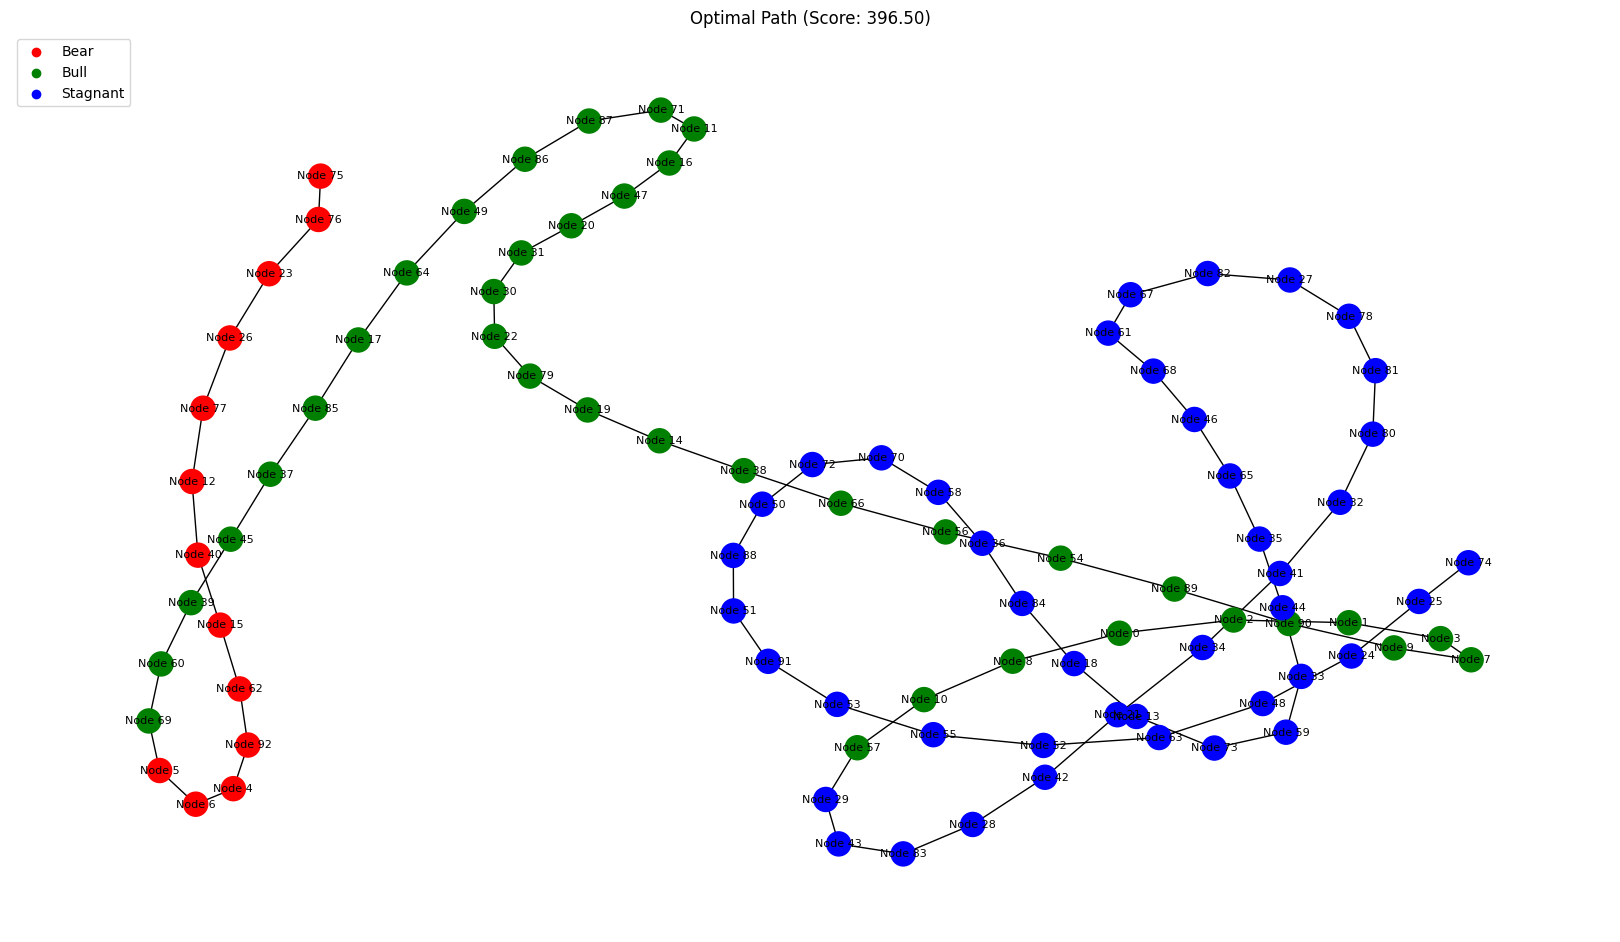

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample data
score, best_solution = final_solution

# Create a NetworkX graph
G = nx.Graph()

# Create nodes and edges based on the best solution
for i, node in enumerate(best_solution):
    label = f"Node {node}"
    if i < 13:
        regime = "Bear"  # Change this to Bull or Stagnant as needed
    elif i < 50:
        regime = "Bull"
    else:
        regime = "Stagnant"
    G.add_node(label, regime=regime)

# Create edges (connecting nodes in the order of the best solution)
for i in range(len(best_solution) - 1):
    node1 = best_solution[i]
    node2 = best_solution[i + 1]
    G.add_edge(f"Node {node1}", f"Node {node2}")

# Define colors for different regimes
node_colors = {
    "Bear": "red",
    "Bull": "green",
    "Stagnant": "blue",
}

# Get the color for each node based on its regime
colors = [node_colors[G.nodes[node]["regime"]] for node in G.nodes]

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Adjust the layout algorithm as needed
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=300, font_size=8)

# Create a legend for node colors
legend_labels = {regime: color for regime, color in node_colors.items()}
for label, color in legend_labels.items():
    plt.scatter([], [], c=color, label=label)

plt.legend(loc="upper left")

# Show the plot
plt.title(f"Optimal Path (Score: {score:.2f})")
plt.show()


In [43]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import BicScore, K2Score

In [47]:
# Initialise Hill Climbing Estimator
hc = HillClimbSearch(train_data);
# best_model = hc.estimate()
expert = BayesianModel();
expert.add_nodes_from(datasets);
expert.add_edges_from([
('STEO.PAPR_NONOPEC.M', 'WTISPLC'),
('STEO.PAPR_OPEC.M', 'WTISPLC'),
('STEO.PATC_OECD.M', 'WTISPLC'),
('STEO.PATC_NON_OECD.M', 'WTISPLC'),
('STEO.RGDPQ_OECD.M', 'STEO.PATC_OECD.M'),
('STEO.RGDPQ_NONOECD.M', 'STEO.PATC_NON_OECD.M'),
]);
model = hc.estimate(expert,scoring_method=BicScore(train_data)); # Performs local hill climb search
model.fit(train_data,
state_names=dict(map(lambda e: (e, [0, 1, 2]), datasets)),
estimator=BayesianEstimator, prior_type="K2");

NameError: name 'datasets' is not defined